# MLP Interpretability and Representation Sparsity of GPT2-small

> Perhaps the most interesting observation is that this analogy seems to suggest that finding and understanding interetable neurons – analogous to understanding variables in a computer program – isn't just one of many interesting questions. Arguably, it's the central task. 

Chris Olah in *Mechanistic Interpretability, Variables, and the Importance of Interpretable Bases*

> interpretability is primarily about mapping net-internal structures to corresponding high-level interpretable structures in the environment... the field of alignment will converge toward primarily working on decoding the internal language of neural nets. That will naturally solidify into a paradigm involving interpretability work on the experiment side, plus some kind of theory work figuring out what kinds of meaningful data structures to map the internals of neural networks to.

John Wentworth in *The Plan - 2022 Update*

> ARC’s current plan for solving ELK (and maybe also deceptive alignment) involves three major challenges: 1. Formalizing probabilistic heuristic argument as an operationalization of “explanation” 2. Finding sufficiently specific explanations for important model behaviors 3. Checking whether particular instances of a behavior are “because of” a particular explanation
All three of these steps are very difficult, but I have some intuition about why steps #1 and #3 should be possible and I expect we’ll see significant progress over the next six months. Unfortunately, there’s no simple intuitive story for why step #2 should be tractable, so it’s a natural candidate for the main technical risk.

Paul Christiano in *Can we efficiently explain model behaviors?*


**Goal**: Develop methodology to localize representation of *specific* features.

Secondary goals: 
- Answer basic questions regarding representation learning and science of deep learning. 
- Test concrete predictions made by Toy Models and SOLU papers.

**Solution**: Sparse Probing. (As the name suggests, a normal probing setup, but where the classifier is sparse.)

Strengths
- Lets you pinpoint specific features (rather than say autoencoder)
- Only need to make probing dataset once, then have automatic for all models
- Good for automatic evalutation of architectural interventions
- Testing for universal features

Weaknesses
- Only one feature at a time
- Relying on a good probe dataset (care required). Especially challenging with rare features in superposition.
- Naive use won't detect duplicates.




In [1]:
import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens
import datasets

from probing_datasets.spacy_supervised import *
from probing_datasets.token_supervised import *
from utils import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'probing_datasets'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = EasyTransformer.from_pretrained("gpt2-small", device=device)
model.eval();
text_dataset = datasets.load_dataset("NeelNanda/pile-10k", split="train");
tokenized_dataset = easy_transformer.utils.tokenize_and_concatenate(
    text_dataset, model.tokenizer, max_length=128, add_bos_token=True
);

Loading model: gpt2-small


Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2-small into EasyTransformer!


Using custom data configuration NeelNanda--pile-10k-72f566e9f7c464ab
Found cached dataset parquet (/Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-062cbc070e46aadc.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-50a0b4ee06282a66.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f233d185500d6d86.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-70a536e9d87d9fcf.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-c0e497692aaf7d60.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-00d072563e3811fc.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-475e6bdcdbdb25b5.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-facaed538bf86822.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f2a878ad5f45085e.arrow


Loading cached processed dataset at /Users/wesgurnee/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-d7e1a7771770006a.arrow


In [5]:
n=300
spacy_feature_datasets = make_spacy_supervised_dataset(
    model, tokenized_dataset, n)

regex_feature_datasets = make_probing_feature_datasets(
    model, tokenized_dataset, token_supervised_conditions, n)

In [6]:
regex_experiment_dir = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results/token_supervised_heuristic'
regex_sp_rdf, regex_h_rdf = load_probing_results(regex_experiment_dir)

spacy_experiment_dir = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results/spacy_supervised_heuristic'
spacy_sp_rdf, spacy_h_rdf = load_probing_results(spacy_experiment_dir)

## Interpretable neurons
We first highlight several neurons which map to a human interpretable textual feature.

In [7]:
interpretable_neurons = [
    ('contains_number', 0, [908]),
    ('is_prep', 10, [2214]),
    ('all_capitals', 5, [858]),
    ('all_numbers', 6, [1912]),
    ('is_not_alphanumeric', 1, [1288]),
    ('is_first_person', 2, [1862]),
    ('is_art_pron', 8, [1751]),
    ('is_prs_pron', 4, [2213]),
]

In [9]:
neuron_activations = get_activations(interpretable_neurons, model, tokenized_dataset)

feature_datasets = regex_feature_datasets | spacy_feature_datasets

sp_rdf = pd.concat([spacy_sp_rdf, regex_sp_rdf])

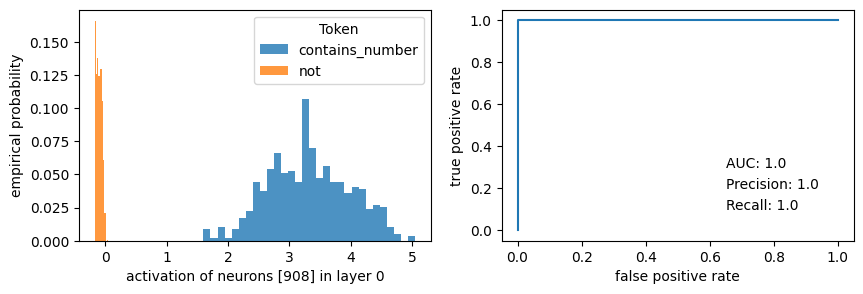

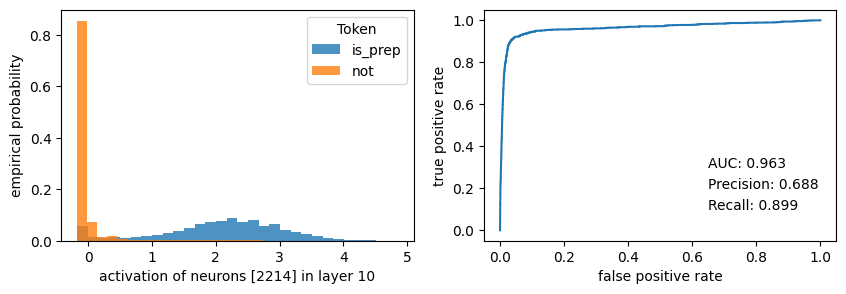

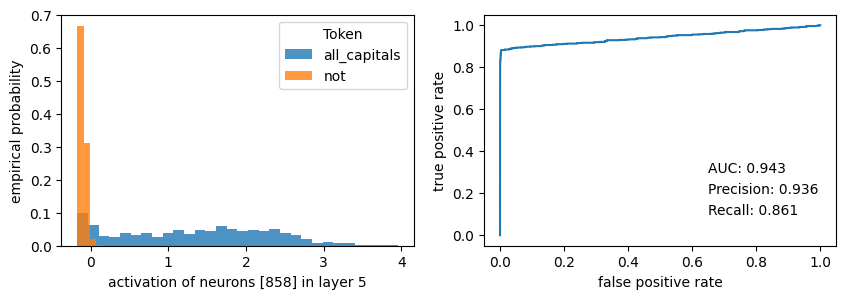

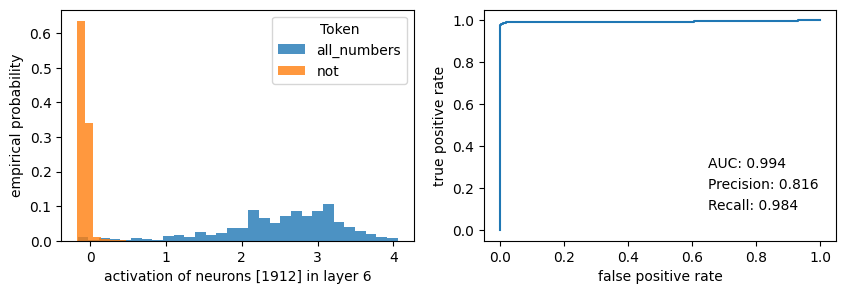

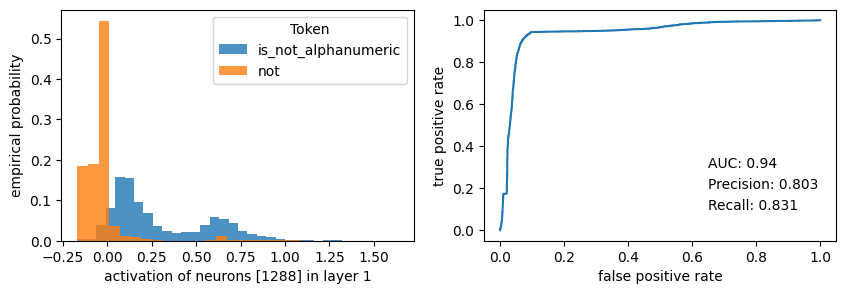

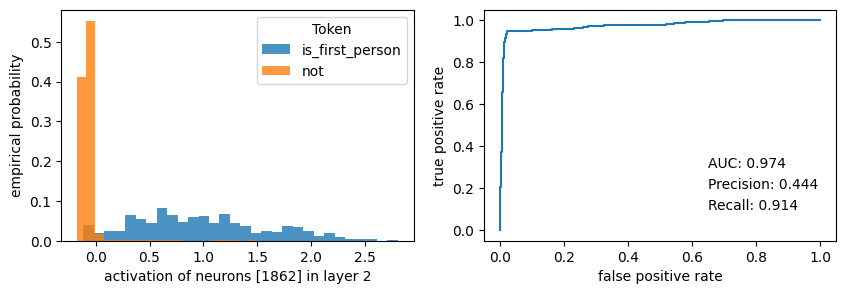

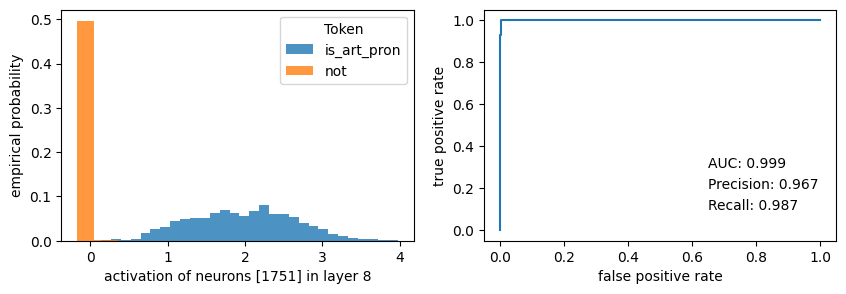

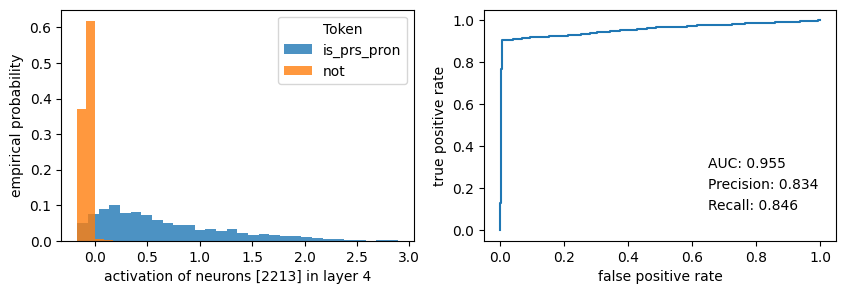

In [10]:
for feature, layer, neurons in interpretable_neurons:
    y = feature_datasets[feature].flatten()
    X = neuron_activations[feature]
    plot_interpretable_neurons(X, y, sp_rdf, feature, layer, neurons)

## Caveats and considerations
- Probing datasets are lazy with negative examples (only random tokens)
- Dataset labels (especially for spacy) may be imperfect
- By design these are features with high prevelance on a relatively small test set (38k tokens).
- GPT2 may be too small to dedicate neurons
- 0.8 AUC for one neuron is still pretty decent (though should really look at precision-recall AUC)

## Error Analysis

In [11]:
for feature, layer, neuron in interpretable_neurons:
    print(f'########### Positive and negative examples for {feature} in MLP L{layer}.{neuron[0]} ###########')
    print_examples(model, tokenized_dataset, neuron_activations, feature_datasets, feature, k=5)

########### Positive and negative examples for contains_number in MLP L0.908 ###########
Most active positive examples of contains_number:
14 5.044296 3
14 4.9768977 77
25 4.775382 7
5 4.7644105 18
20 4.710108 8
Least active positive examples of contains_number:
 1984 1.5982761 40
 1974 1.6484858 56
 1966 1.7043855 89
 1999 1.7046628 50
 1965 1.7084143 33
Most active negative examples of contains_number:
PO 0.4124377 25
ente 0.25957602 7
pdf 0.21277288 15
pdf 0.18633936 75
NL 0.17093325 56
########### Positive and negative examples for is_prep in MLP L10.2214 ###########
Most active positive examples of is_prep:
 from 4.8488913 109
 from 4.7700047 120
 in 4.6194158 33
 in 4.5797534 39
 by 4.4428053 51
Least active positive examples of is_prep:
^ -0.1700405 73
as -0.1700389 29
 like -0.16999224 58
According -0.16983703 15
According -0.1696486 25
Most active negative examples of is_prep:
 to 4.457278 105
 to 4.162093 71
 to 4.036611 77
 of 3.920501 84
 to 3.8837516 30
########### Positiv

## Sparse Classification
### Optimal
Proof. For *weighted* regularized classification, we have that
$$
\min _{\boldsymbol{\beta}} \sum_{i=1}^n w_i \ell\left(y_i, \boldsymbol{\beta}^T \mathbf{x}_i\right)+\frac{1}{2 \gamma}\|\boldsymbol{\beta}\|_2^2=\min _{\boldsymbol{\beta}, \mathbf{z}} \sum_{i=1}^n w_i \ell\left(y_i, z_i\right)+\frac{1}{2 \gamma}\|\boldsymbol{\beta}\|_2^2 \quad \text { s.t. } z_i=\boldsymbol{\beta}^T \mathbf{x}_i \text {. }
$$
The objective is convex, the optimization set is convex, and Slater's conditions hold. Hence, strong duality must hold and the primal is equivalent to the dual problem. To derive the dual formulation, we introduce Lagrange multipliers $\alpha_i$ associated with the equality constraints:

\begin{align*}
& \min _{\boldsymbol{\beta}, \mathbf{z}} \sum_{i=1}^n w_i \ell\left(y_i, z_i\right)+\frac{1}{2 \gamma}\|\boldsymbol{\beta}\|_2^2 \text \quad { s.t. } z_i=\boldsymbol{\beta}^T \mathbf{x}_i \\
& =\min _{\boldsymbol{\beta}, \mathbf{z}} \sum_{i=1}^n w_i \ell\left(y_i, z_i\right)+\frac{1}{2 \gamma}\|\boldsymbol{\beta}\|_2^2+\max _{\boldsymbol{\alpha} \in \mathbb{R}^n} \sum_{i=1}^n \alpha_i\left(\boldsymbol{\beta}^T \mathbf{x}_i-z_i\right) \\
& =\min _{\boldsymbol{\beta}, \mathbf{z}} \max _{\boldsymbol{\alpha}}\left(\sum_{i=1}^n w_i \ell\left(y_i, z_i\right)-\alpha_i z_i\right)+\left(\frac{1}{2 \gamma}\|\boldsymbol{\beta}\|^2+\boldsymbol{\beta}^T\left[\sum_{i=1}^n \alpha_i \mathbf{x}_i\right]\right) \\
& =\max _{\boldsymbol{\alpha}} \sum_{i=1}^n \min _{z_i}\left(w_i \ell\left(y_i, z_i\right)-\alpha_i z_i\right)+\min _{\boldsymbol{\beta}}\left(\frac{1}{2 \gamma}\|\boldsymbol{\beta}\|^2+\boldsymbol{\beta}^T \mathbf{X}^T \boldsymbol{\alpha}\right) .
\end{align*}

Let us consider the inner minimization problems separately. First,
$$
\min _{z_i}\left(w_i \ell\left(y_i, z_i\right)-\alpha_i z_i\right)=-\max _{z_i}\left(\alpha_i z_i-w_i \ell\left(y_i, z_i\right)\right)=- w_i \hat{\ell}\left(y_i, \frac{\alpha_i}{w_i} \right)
$$
Then, $(1 / 2 \gamma)\|\boldsymbol{\beta}\|^2+\boldsymbol{\beta}^T \mathbf{X}^T \boldsymbol{\alpha}$ is minimized at $\boldsymbol{\beta}^*$ satisfying: $(1 / \gamma) \boldsymbol{\beta}^*+$ $\mathbf{X}^T \boldsymbol{\alpha}=\mathbf{0}$. Hence,
$$
\min _{\boldsymbol{\beta}}\left(\frac{1}{2 \gamma}\|\boldsymbol{\beta}\|^2+\boldsymbol{\beta}^T \mathbf{X}^T \boldsymbol{\alpha}\right)=-\frac{1}{2 \gamma}\left\|\boldsymbol{\beta}^*\right\|^2=-\frac{\gamma}{2} \boldsymbol{\alpha}^T \mathbf{X} \mathbf{X}^T \boldsymbol{\alpha}
$$
as desired.

For the weighted hinge loss $w_i\ell(y, u) = w_i\max(0, 1 - yu)$ we have that
$$ w_i\hat{\ell}(y, \alpha / w_i) = \begin{cases}y \alpha \quad \text{if } y \alpha / w_i \in [-1, 0] \\
+\infty \quad \text{otherwise}\end{cases}$$

### Heuristics
- Iterative fitting schemes
    - Thresholding
    - Orthogonal matching persuit
    - Greedy addition or deletion
- Heuristic feature selection
    - Mutual information
    - f_statistic
    - coefficient magntitude
    - combination

## Representation sparsity

For ~50 human interpretable features, we train probes of varying sparsity for all layers to understand how sparse vs. distributed representations are.

A note on feature types. A feature may be binary, categorial, or continuous and  be
1. A property of a single token (e.g., is number)
1. A property of one thing which is tokenized into multiple parts (e.g., phone number or email)
1. A property of a small sequence (e.g., dependency parsing)
1. A property of a full sequence (e.g., sentiment)

For simplicity, we mostly focus on binary features of a single token (those sometimes the lines above are a bit blurry, as with dependency parsing).

## Interpreting Metrics

### Sparse Regime

#### High precision and high recall
We have identified one place where the network faithfully represents a particular feature. It could be that the feature is also represented elsewhere in the same layer. It also could be superimposed with some much rarer feature.

#### High precision and low recall
Our feature is too general. Network's ontology captures a more specific subcategory of that feature.

#### Low precision and high recall
Two possibilities
- Our feature is too specific, the neurons actually correspond to some superset of the feature in question.
- Polysemantic neuron which is directly mapped to this feature, but also sometimes is used to represent other features.

### Dense Regime

#### High AUC
The network linearly represents this feature, but it is highly distributed.

#### Low AUC
The feature is not linearly represented in the network. Either not in the network ontology or is represented nonlinearly.



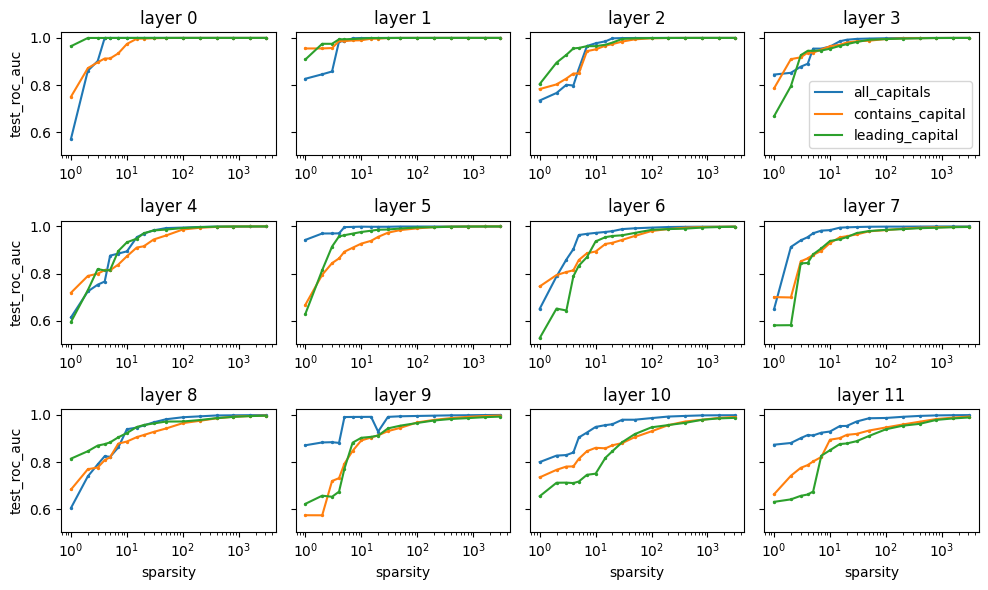

In [12]:
features = ['all_capitals', 'contains_capital', 'leading_capital']
plot_metric_over_sparsity_per_layer(regex_sp_rdf, features)

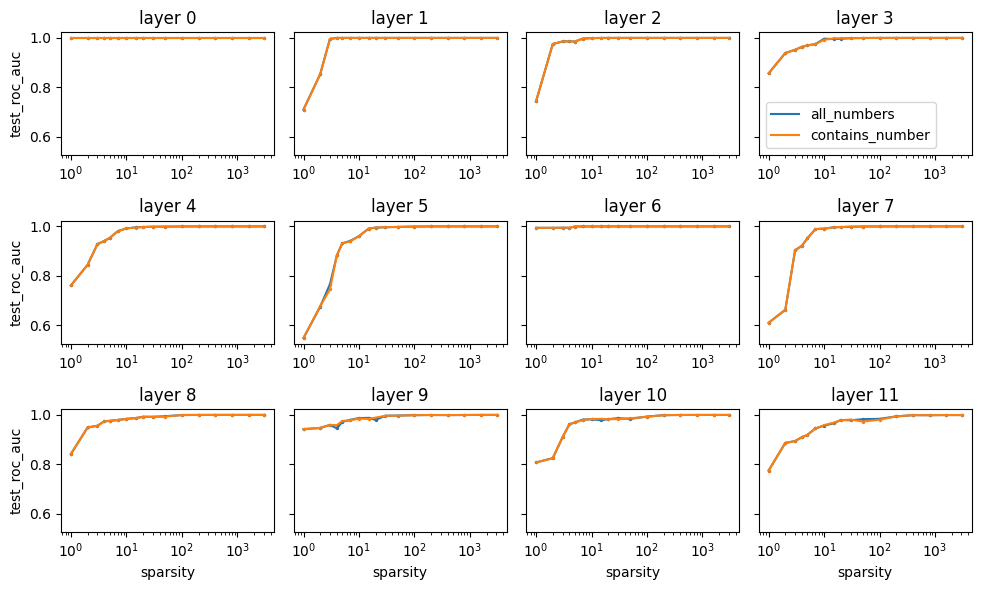

In [13]:
features = ['all_numbers', 'contains_number']
plot_metric_over_sparsity_per_layer(regex_sp_rdf, features)

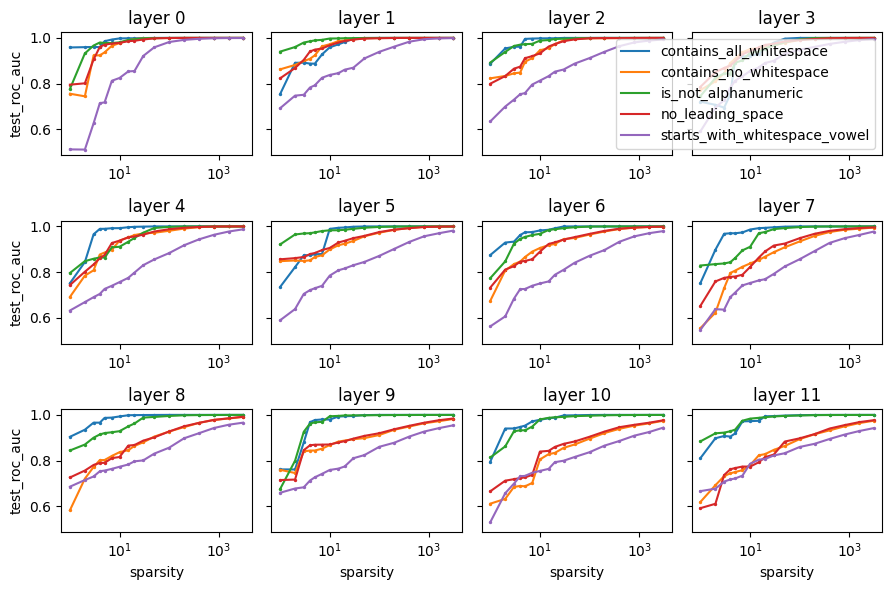

In [14]:
features = ['contains_all_whitespace', 'contains_no_whitespace', 'is_not_alphanumeric', 'no_leading_space', 'starts_with_whitespace_vowel']
plot_metric_over_sparsity_per_layer(regex_sp_rdf, features)

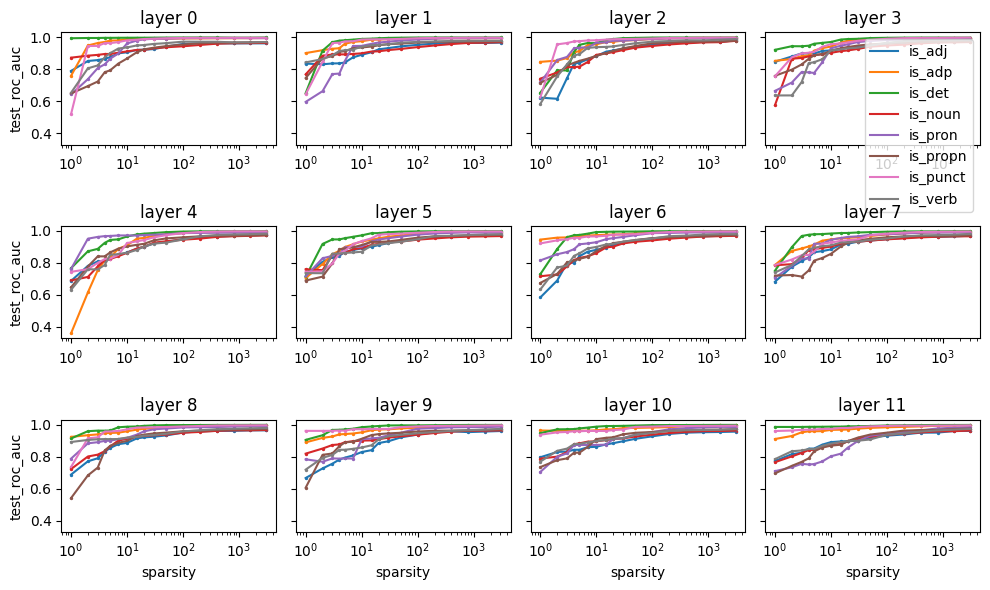

In [15]:
pos_features = ['is_adj', 'is_adp','is_det','is_noun','is_pron','is_propn','is_punct','is_verb']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, pos_features)

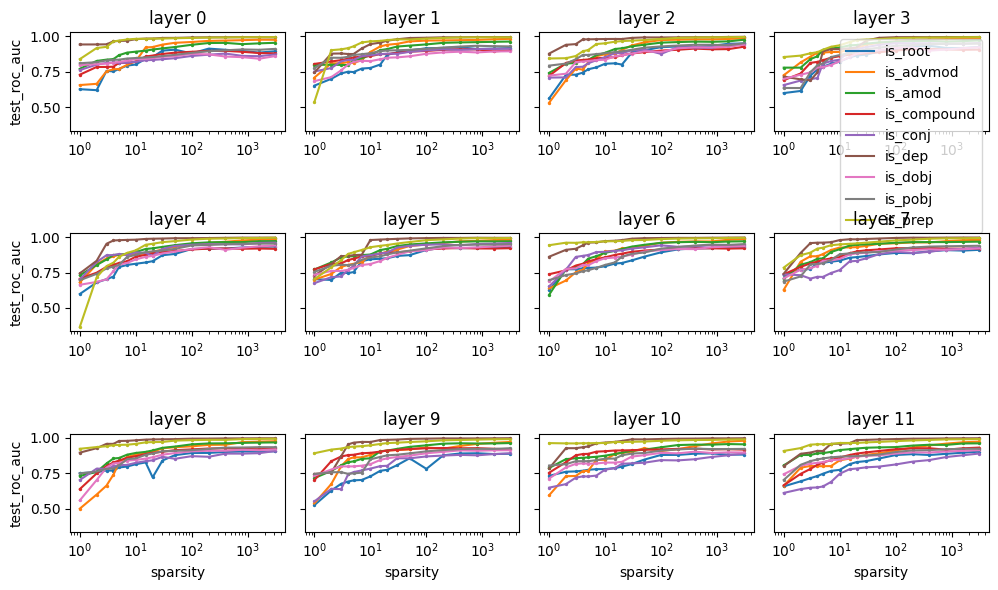

In [16]:
dep_features = ['is_root', 'is_advmod', 'is_amod', 'is_compound', 'is_conj', 'is_dep', 'is_dobj', 'is_pobj', 'is_prep']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, dep_features)

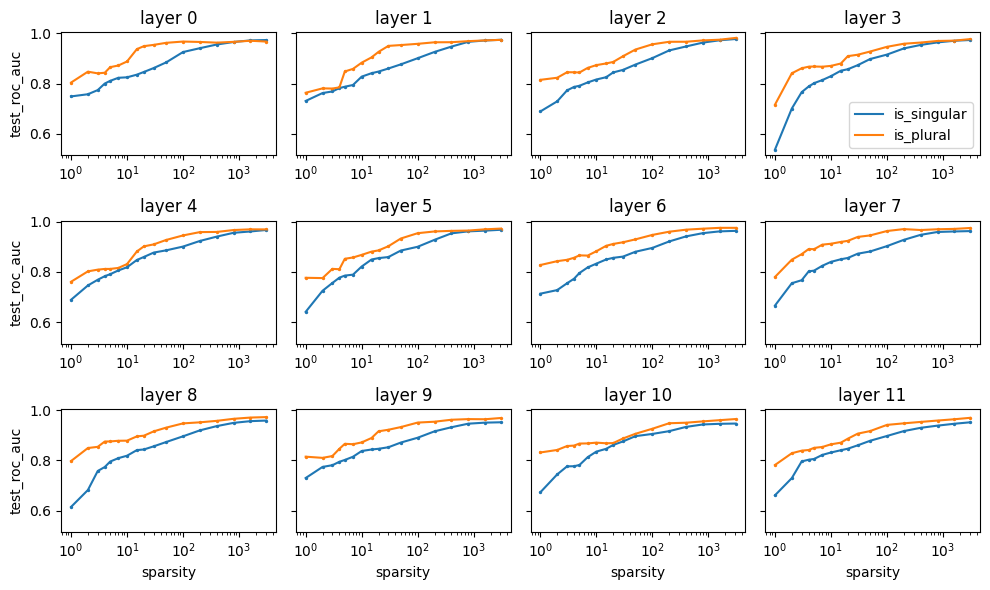

In [17]:
morph_features = ['is_singular', 'is_plural']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, morph_features)

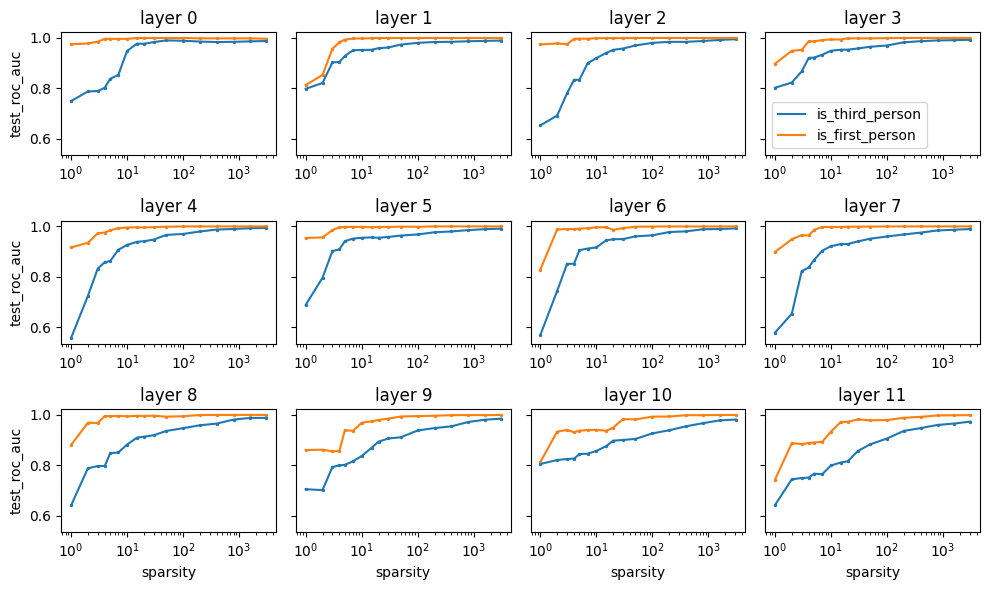

In [18]:
morph_features = ['is_third_person', 'is_first_person']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, morph_features)

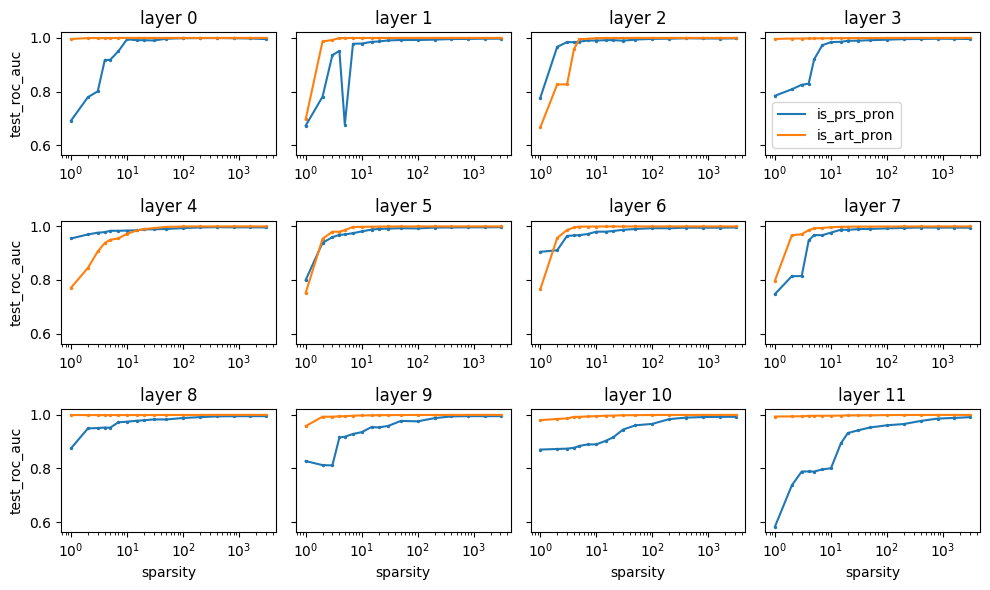

In [19]:
morph_features = ['is_prs_pron', 'is_art_pron']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, morph_features)

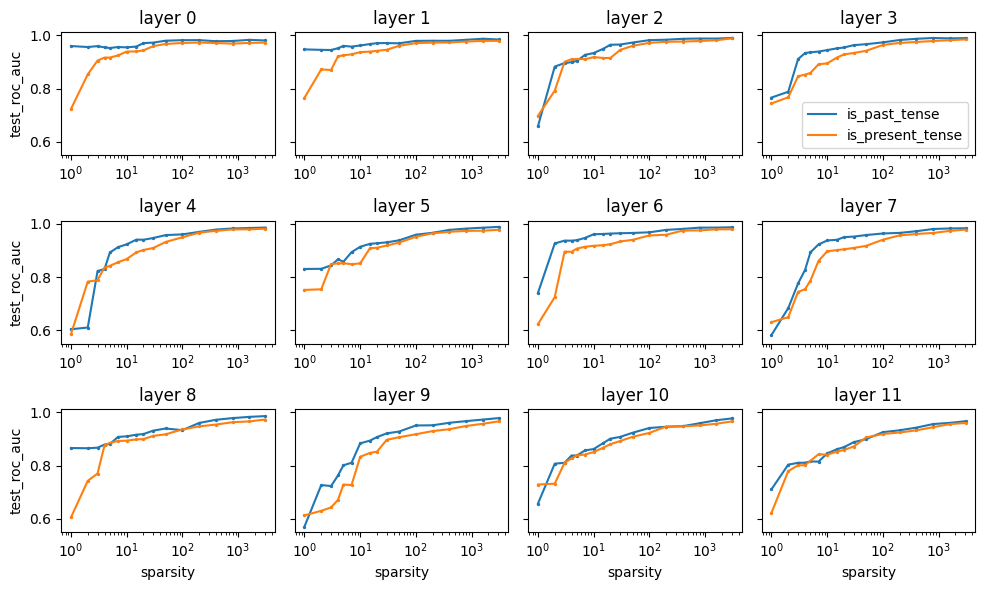

In [20]:
morph_features = ['is_past_tense', 'is_present_tense']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, morph_features)

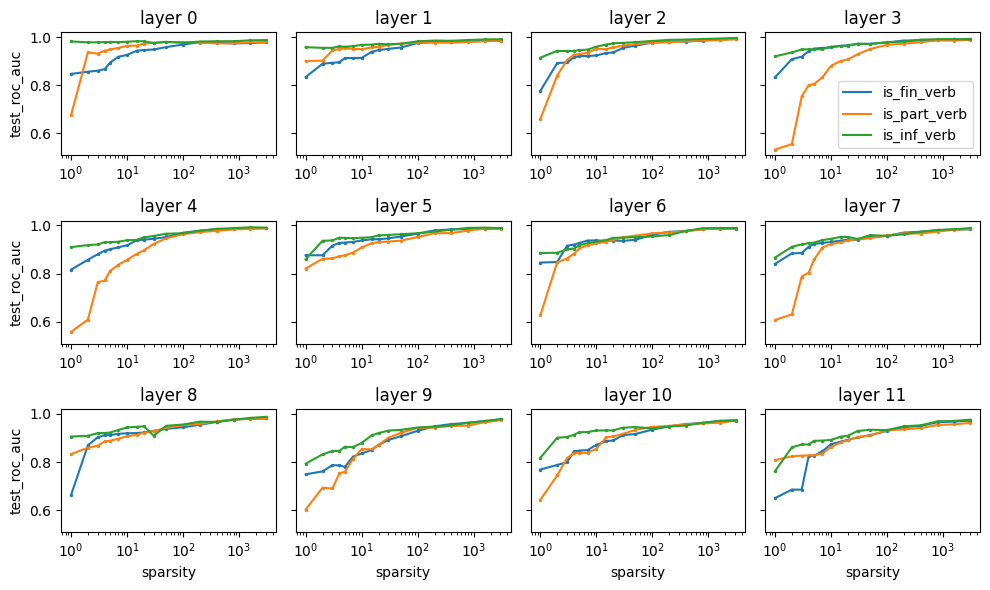

In [21]:
morph_features = ['is_fin_verb', 'is_part_verb', 'is_inf_verb']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, morph_features)

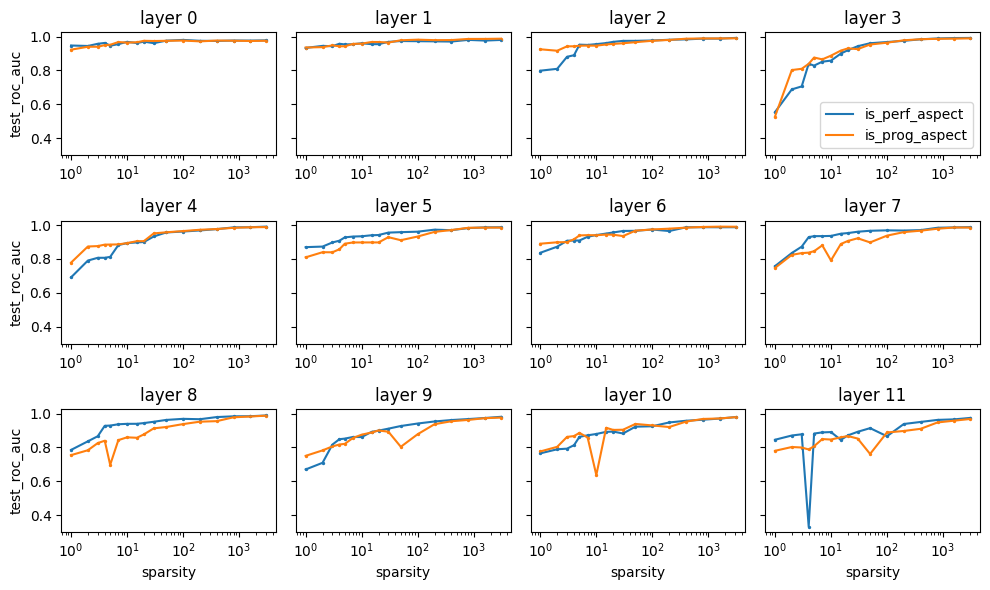

In [22]:
morph_features = ['is_perf_aspect', 'is_prog_aspect']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, morph_features)

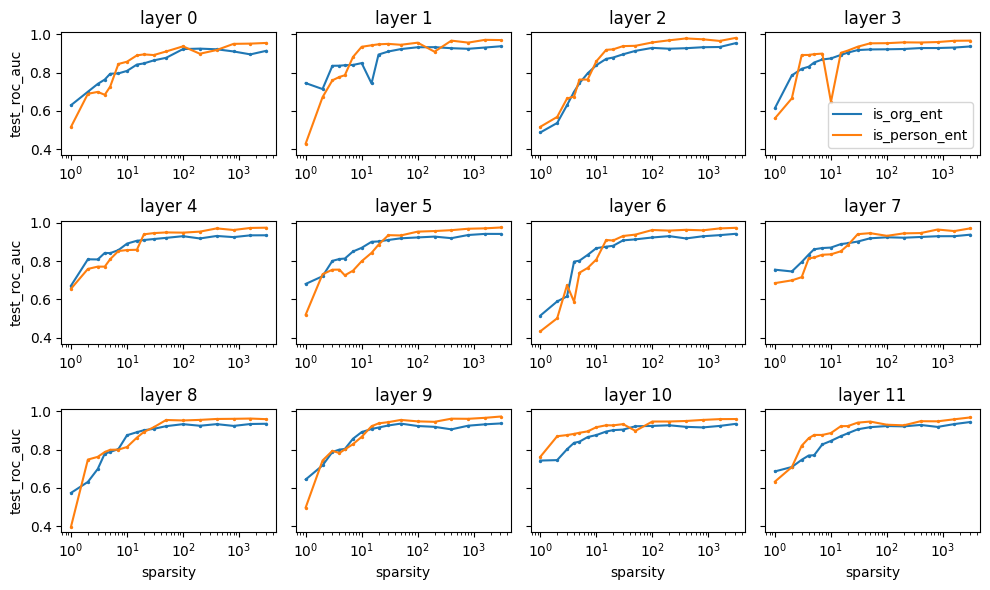

In [23]:
entity_features = ['is_org_ent', 'is_person_ent']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, entity_features)

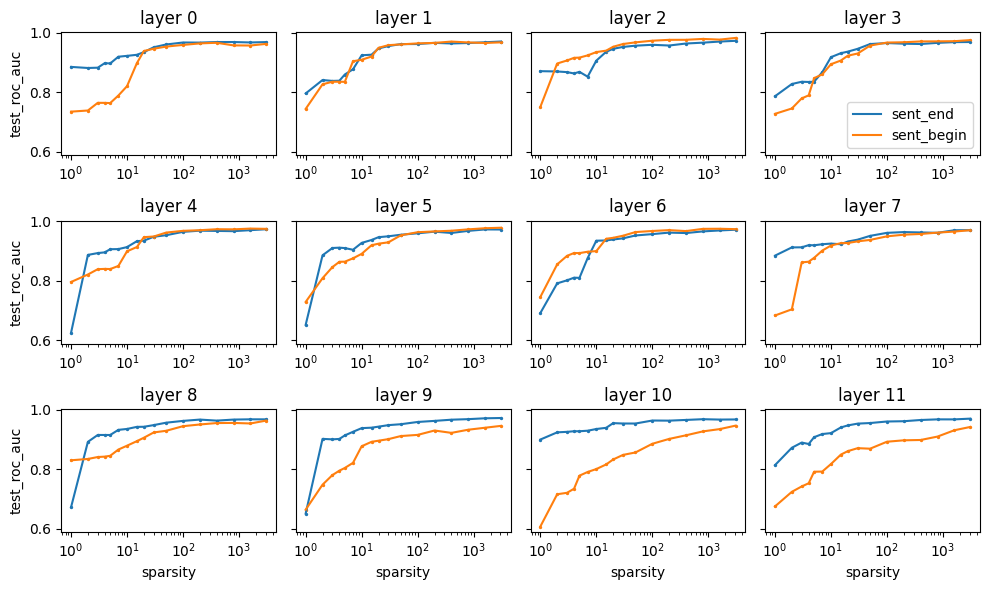

In [24]:
sent_features = ['sent_end', 'sent_begin']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, sent_features)

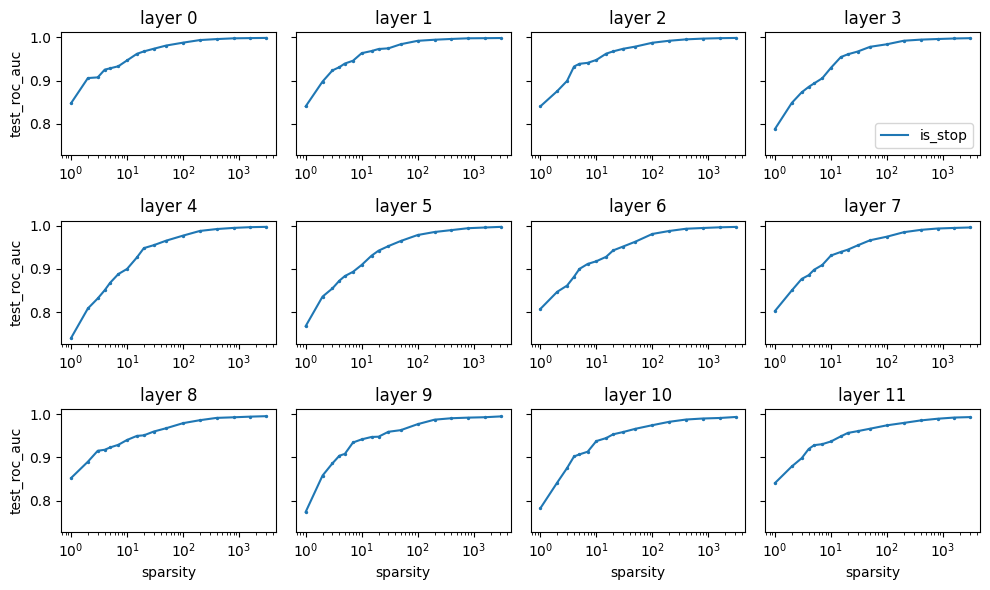

In [25]:
stop_features = ['is_stop']
plot_metric_over_sparsity_per_layer(spacy_sp_rdf, stop_features)

## Next steps

### Short Term
- Save full precision-recall curves (and make plotly!)
- More careful design of probing datasets (include both true negative class and random tokens, make bigger)
- More careful error analysis, iterate on finding features faithfully in the ontology
- Detailed experiments on design of heuristics vs. optimal sparse classification

### Medium Term (end of Jan; first paper)
- More datasets, track feature occurence vs. representation sparsity (to test prediction of the toy models paper)
- Test that MLP neurons are the only units which have representation sparsity
- Bigger models. Does sparsity increase?
- GeLU vs. SOLU. More sparse? Generally good for automatic evaluation

### Longer Term (end of May; second and third papers)
Scale engagements with undergrads at MIT and Harvard
- Extend methodology and interpret all the things
    - Develop and test methodology for continuous and categorial features
    - Better understand encoding of features which span multiple tokens (e.g., ROME paper seemed to suggest factual info is stored in the last position)
    - Begin to probe alignment relevant behavior (deception, optimization)
- Universality and path dependence
    - Compare consistency of representations across random intializations of same model (e.g., GPT2-{small, medium}-{a-e})
    - Compare consistency of representations across similar sized models with architectural differences (e.g, GPTJ)
    - Compare consistency of representations across models of varying sizes
    - Compare consistency of representations across training (e.g., checkpoints of GPT2-{small, medium}-{a-e})